# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](http://yann.lecun.com/exdb/mnist/) and include:

88% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
95.3% [Lecun et al., 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)

MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Imports

In [19]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [3]:
# Defining transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading the dataset
mnist_dataset = torchvision.datasets.MNIST(root="data", train=True, download=True, transform=transform)

# Defining the sizes of train, validation, and test sets
train_size = int(0.6 * len(mnist_dataset))  # 60% for training
val_size = int(0.2 * len(mnist_dataset))    # 20% for validation
test_size = len(mnist_dataset) - train_size - val_size  # Remaining for test (20%)

# Splitting the MNIST dataset 

train_dataset, val_dataset, test_dataset = random_split(mnist_dataset, [train_size, val_size, test_size])

# Create test set and define test dataloader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

**The only preprocessing made was "Normlization" to convert the grayscale values to tensors with numbers between 0 and 1. The image size in this dataset seems perfect - 28*28 - and we will not need to rotate images or flip them since we will predict images which are always in the right rotations (for example, number four flipped is not actually four)**

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [4]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

4


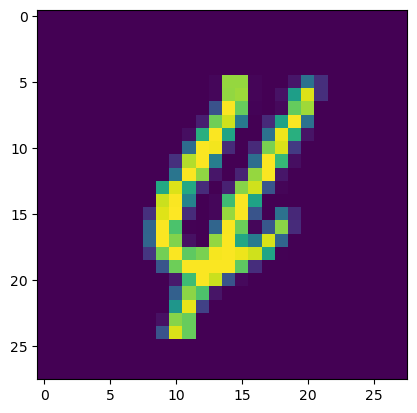

9


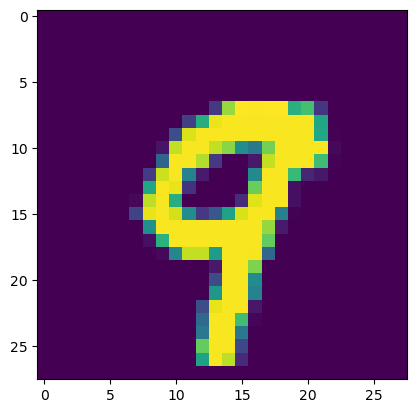

8


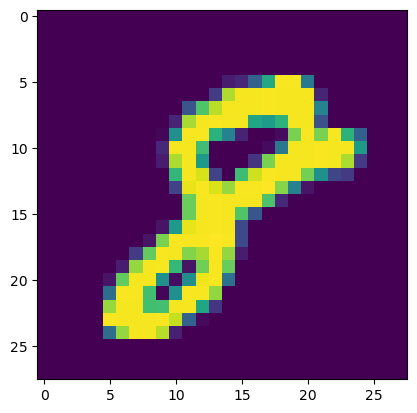

7


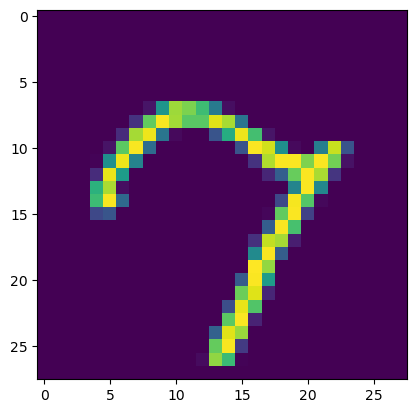

9


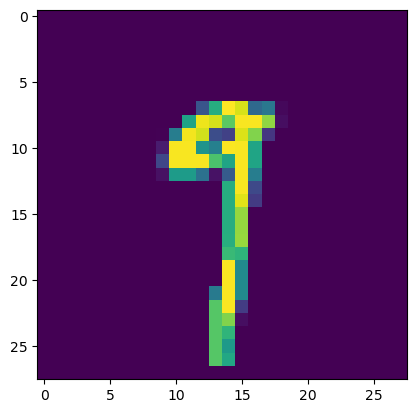

In [6]:
# Explore data
show5(train_loader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = F.relu
        self.layer1 = nn.Linear(28 * 28 * 1, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.layer4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        x = self.layer4(x)
        x = F.softmax(x, dim=1)
        return x

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [8]:
net = Net()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.99, weight_decay=0.001)
criterion = nn.CrossEntropyLoss()

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
# Move the model to the GPU if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

In [72]:
# number of epochs
num_epochs = 20

# creating lists for loss history
train_loss_history = list()
val_loss_history = list()

# The start of the training
for epoch in range(num_epochs):
    # putting the model in training mode
    net.train()
    # setting the epoch loss and number of correct predictions to zero
    train_loss = 0.0
    train_correct = 0
    total_predictions = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
    
        outputs = net(inputs)
    
        loss = criterion(outputs, labels)
    
        loss.backward()
    
        optimizer.step()
    
        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
    print(f"Epoch {epoch + 1} training accuracy: {train_correct/total_predictions * 100:.2f}% training loss: {train_loss/len(train_loader):.5f}")
    train_loss_history.append(train_loss/len(train_loader))
    
    # The validation phase
    val_loss = 0.0
    val_correct = 0
    total_predictions = 0
    net.eval()
    for inputs, labels in val_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f"Epoch {epoch + 1} validation accuracy: {val_correct/total_predictions * 100:.2f}% validation loss: {val_loss/len(val_loader):.5f}")
    val_loss_history.append(val_loss/len(val_loader))

Epoch 1 training accuracy: 35.43% training loss: 2.13648
Epoch 1 validation accuracy: 57.43% validation loss: 1.88620
Epoch 2 training accuracy: 56.59% training loss: 1.89395
Epoch 2 validation accuracy: 58.50% validation loss: 1.87451
Epoch 3 training accuracy: 58.17% training loss: 1.87735
Epoch 3 validation accuracy: 59.22% validation loss: 1.86554
Epoch 4 training accuracy: 64.78% training loss: 1.81244
Epoch 4 validation accuracy: 72.98% validation loss: 1.73084
Epoch 5 training accuracy: 74.97% training loss: 1.71195
Epoch 5 validation accuracy: 79.39% validation loss: 1.66960
Epoch 6 training accuracy: 79.07% training loss: 1.67129
Epoch 6 validation accuracy: 82.38% validation loss: 1.64213
Epoch 7 training accuracy: 86.37% training loss: 1.60014
Epoch 7 validation accuracy: 89.29% validation loss: 1.57105
Epoch 8 training accuracy: 89.32% training loss: 1.56935
Epoch 8 validation accuracy: 91.12% validation loss: 1.55454
Epoch 9 training accuracy: 91.22% training loss: 1.55147

Plot the training loss (and validation loss/accuracy, if recorded).

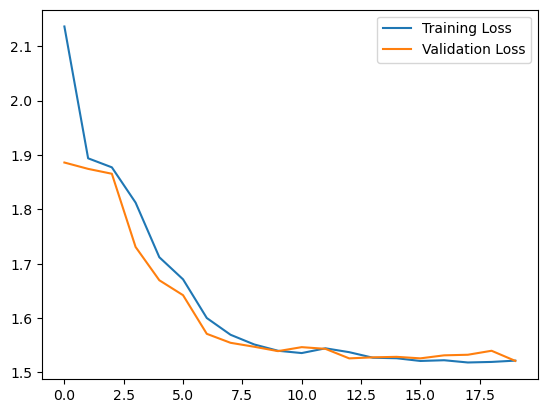

In [73]:
plt.plot(train_loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend()
plt.show()

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [74]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100
    
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 94.43%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

### For improving the model, I decreased the learning rate from 0.01 to 0.001. The first training phase was for finding the right weights and taking huge steps to find them. The second one - the one in the coming code cells - is to take smaller steps to fine-tune the model and get a better accuracy

In [75]:
# exprimenting with the optimizer

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.99, weight_decay= 0.001)

In [76]:
# number of epochs
num_epochs = 20

# creating lists for loss history
train_loss_history = list()
val_loss_history = list()

# The start of the training
for epoch in range(num_epochs):
    # putting the model in training mode
    net.train()
    # setting the epoch loss and number of correct predictions to zero
    train_loss = 0.0
    train_correct = 0
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
    
        optimizer.zero_grad()
    
        outputs = net(inputs)
    
        loss = criterion(outputs, labels)
    
        loss.backward()
    
        optimizer.step()
    
        _, preds = torch.max(outputs.data, 1)
        train_correct += (preds == labels).sum().item()
        train_loss += loss.item()
        
    print(f"Epoch {epoch + 1} training accuracy: {train_correct/len(train_loader.dataset) * 100:.2f}% training loss: {train_loss/len(train_loader):.5f}")
    train_loss_history.append(train_loss/len(train_loader))
    
    # The validation phase
    val_loss = 0.0
    val_correct = 0
    net.eval()
    for inputs, labels in test_loader:
        if torch.cuda.is_available():
            inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == labels).sum().item()
        val_loss += loss.item()
    print(f"Epoch {epoch + 1} validation accuracy: {val_correct/len(test_loader.dataset) * 100:.2f}% validation loss: {val_loss/len(test_loader):.5f}")
    val_loss_history.append(val_loss/len(test_loader))

Epoch 1 training accuracy: 96.12% training loss: 1.50357
Epoch 1 validation accuracy: 95.92% validation loss: 1.50661
Epoch 2 training accuracy: 96.70% training loss: 1.49807
Epoch 2 validation accuracy: 96.07% validation loss: 1.50431
Epoch 3 training accuracy: 96.89% training loss: 1.49636
Epoch 3 validation accuracy: 96.04% validation loss: 1.50452
Epoch 4 training accuracy: 97.15% training loss: 1.49510
Epoch 4 validation accuracy: 96.22% validation loss: 1.50373
Epoch 5 training accuracy: 97.26% training loss: 1.49475
Epoch 5 validation accuracy: 96.26% validation loss: 1.50335
Epoch 6 training accuracy: 97.34% training loss: 1.49422
Epoch 6 validation accuracy: 96.22% validation loss: 1.50381
Epoch 7 training accuracy: 97.39% training loss: 1.49401
Epoch 7 validation accuracy: 96.28% validation loss: 1.50350
Epoch 8 training accuracy: 97.47% training loss: 1.49317
Epoch 8 validation accuracy: 96.27% validation loss: 1.50365
Epoch 9 training accuracy: 97.56% training loss: 1.49256

## Final accuracy after tweaking the model


In [78]:
correct_predictions = 0
total_predictions = 0

for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    accuracy = (correct_predictions / total_predictions) * 100
    
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 96.54%


## Saving your model
Using `torch.save`, save your model for future loading.

In [10]:
torch.save(net.state_dict(), "saved_model.pth")

# Implementing sanity checking


**This part was implemented later. So, to avoid training the model again, we will load the the already trained checkpoint right away**

In [11]:
# Assuming your model class is called Net
net = Net()

# Load the saved model
model_path = "saved_model.pth"
checkpoint = torch.load(model_path)

# Check if the 'model_state_dict' key is present in the checkpoint
if 'model_state_dict' in checkpoint:
    # Load the model's state_dict
    net.load_state_dict(checkpoint['model_state_dict'])
    print("Model loaded successfully.")
else:
    # If the key is not present, try loading the entire state dictionary
    net.load_state_dict(checkpoint)
    print("Model loaded successfully (full state dictionary).")

# If you also saved optimizer state, you can load it as well
if 'optimizer_state_dict' in checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# If you saved other information such as training epochs or loss history, you can load them too
# For example, if you saved the number of epochs
if 'epoch' in checkpoint:
    epoch = checkpoint['epoch']

# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)
net.eval()


Model loaded successfully (full state dictionary).


Net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=10, bias=True)
)

## Visualizing the predications (actual vs predicted)

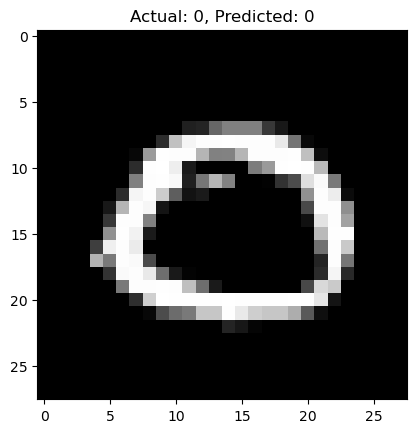

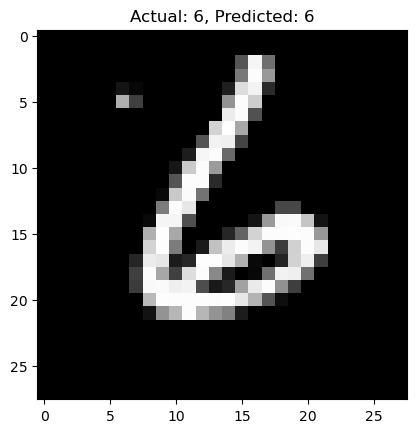

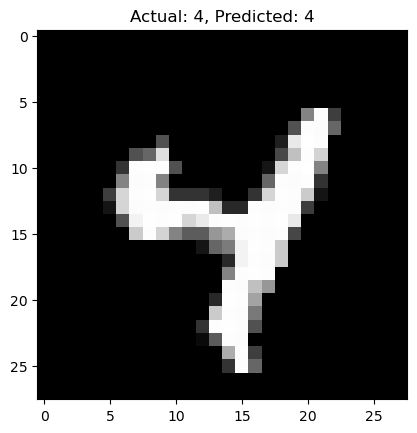

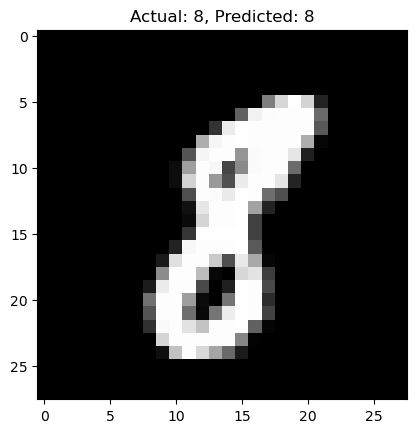

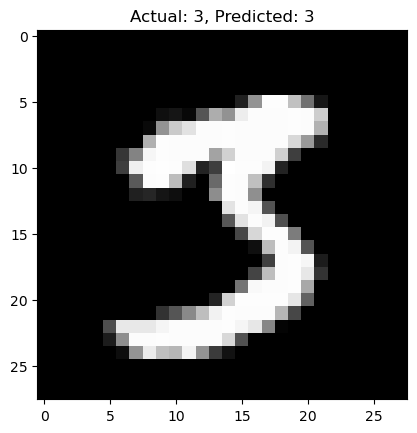

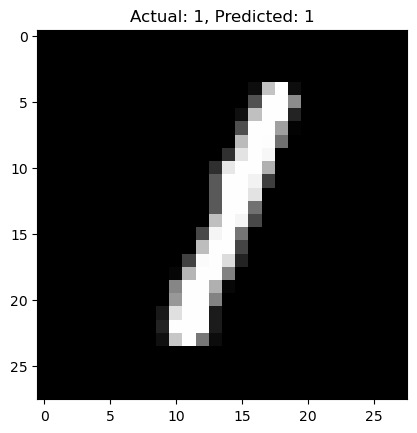

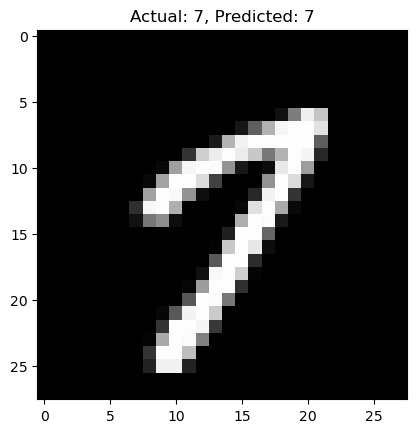

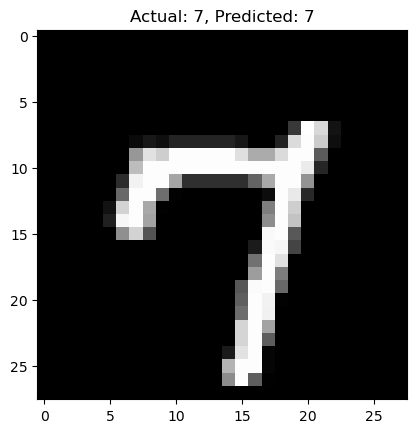

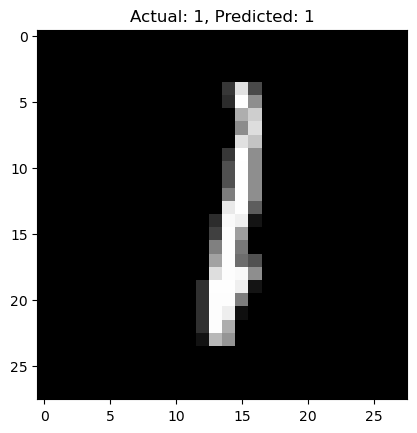

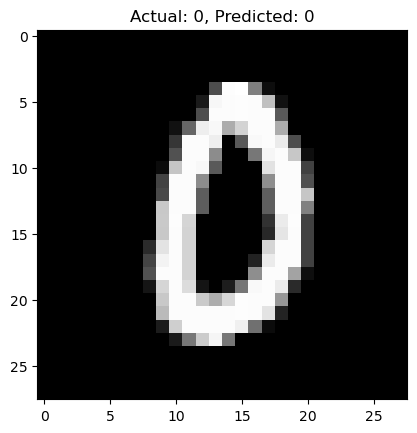

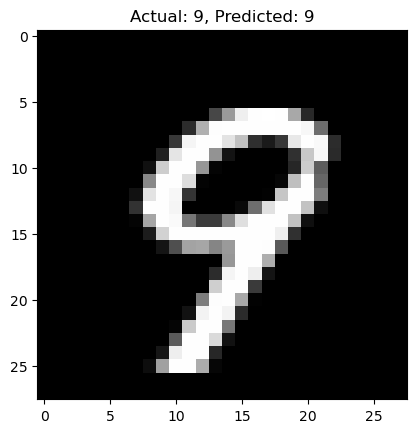

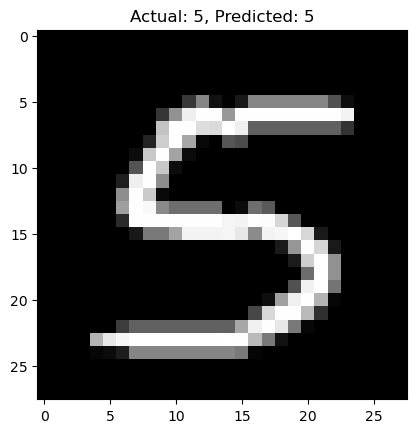

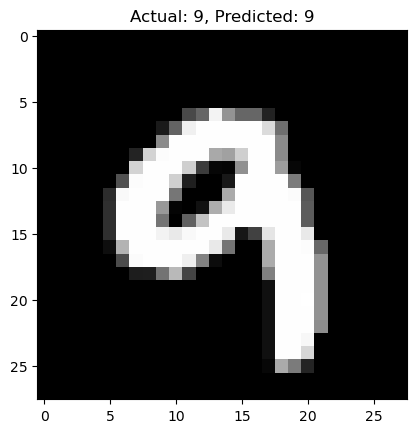

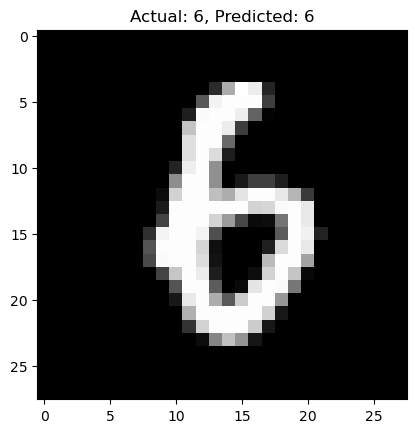

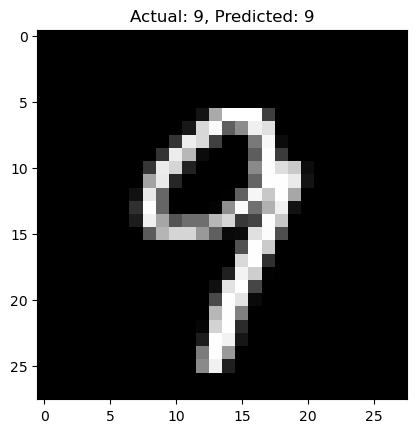

In [23]:
def visualize_results(model, dataloader, device):
    model.eval()

    # Get the total number of samples in the dataset
    total_samples = len(dataloader.dataset)

    # Randomly select 15 indices
    random_indices = random.sample(range(total_samples), 15)

    with torch.no_grad():
        for idx in random_indices:
            inputs, labels = dataloader.dataset[idx]
            inputs, labels = inputs.unsqueeze(0).to(device), torch.tensor([labels]).to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Convert tensors to NumPy arrays
            inputs = inputs.cpu().numpy()
            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()

            # Display the sample
            plt.imshow(np.squeeze(inputs), cmap='gray')
            plt.title(f"Actual: {labels.item()}, Predicted: {preds[0]}")
            plt.show()

# Call the function with the model and the test dataloader
visualize_results(net, test_loader, device)

## Confusion matrix

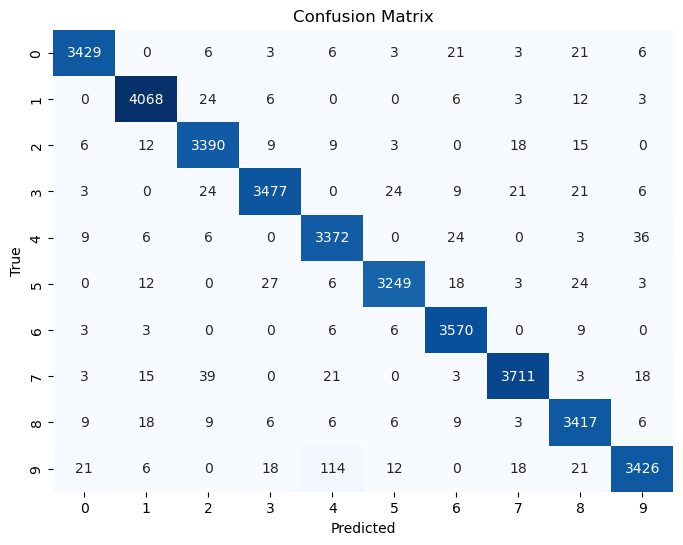

In [24]:
for inputs, labels in test_loader:
    if torch.cuda.is_available():
        inputs, labels = inputs.to(device), labels.to(device)
        
    outputs = net(inputs)
    _, preds = torch.max(outputs.data, 1)
    
    total_predictions += labels.size(0)
    correct_predictions += (preds == labels).sum().item()
    
    # Append predictions and labels for confusion matrix
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Create a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()